## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for object recognition ([cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html)) using [PyTorch](http://pytorch.org). 

In Problem 1, you will use the pre-trained features from a given CNN backbone network, and train a simple neural network consisting of a couple of feedforward layers and a classification layer. You will need to implement the loss function.

In Problem 2, you will implement your own CNN model, initialize model weights randomly and train from scratch.

In Problem 3, you will modify the given pre-trained CNN model and fine-tune model weights with the training data.


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation). By default, Colab has installed PyTorch.
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.
- Stanford cs231n class at https://cs231n.github.io/.

## A Few Terminologies
---
If you are unfamilar with deep learing terminologies, here is a brief tutorial https://www.analyticsvidhya.com/blog/2017/05/25-must-know-terms-concepts-for-beginners-in-deep-learning/

Some important concepts include:

Cost Function, Learning Rate, Batches, Epochs, Batch Normalization, Filters, CNN, Pooling




In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
import os
os.chdir("xxxx")

## Problem 0: Get Pre-trained CNN model from Cifar-100

The model is pre-trained with Cifar-100 for 100 class classification.

Model file is provided. 

Adapted from https://zhenye-na.github.io/2018/10/07/pytorch-resnet-cifar100.html

In [ ]:
# Normalize training set together with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
            download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
            download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
            shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    """3x3 kernel size with padding convolutional layer in ResNet BasicBlock."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


class BasicBlock(nn.Module):
    """Basic Block of ReseNet."""

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Basic Block of ReseNet Builder."""
        super(BasicBlock, self).__init__()

        # First conv3x3 layer
        self.conv1 = conv3x3(in_channels, out_channels, stride)

        #  Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        # ReLU Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Second conv3x3 layer
        self.conv2 = conv3x3(out_channels, out_channels)

        #  Batch Normalization
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # downsample for `residual`
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """Forward Pass of Basic Block."""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out

In [ ]:
class ResNet(nn.Module):
    """Residual Neural Network."""

    def __init__(self, num_classes=100):
        block = BasicBlock
        duplicates = [2,4,4,2]

        """Residual Neural Network Builder."""
        super(ResNet, self).__init__()

        self.in_channels = 32
        self.conv1 = conv3x3(in_channels=3, out_channels=32)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.02)

        # block of Basic Blocks
        self.conv2_x = self._make_block(block, duplicates[0], out_channels=32)
        self.conv3_x = self._make_block(block, duplicates[1], out_channels=64, stride=2)
        self.conv4_x = self._make_block(block, duplicates[2], out_channels=128, stride=2)
        self.conv5_x = self._make_block(block, duplicates[3], out_channels=256, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights
        # self.apply(initialize_weights)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_block(self, block, duplicates, out_channels, stride=1):
        """
        Create Block in ResNet.

        Args:
            block: BasicBlock
            duplicates: number of BasicBlock
            out_channels: out channels of the block

        Returns:
            nn.Sequential(*layers)
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, duplicates):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)


    def pretrained_feature(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        return out.detach()
    
    def forward(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

pretrainNet = ResNet().cuda()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class PreTrainNet(nn.Module):
    def __init__(self):
        super(PreTrainNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 8, 3)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 100)

    def feature(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def pretrained_feature(self, x):
        return x.detach()

    def forward(self, x):
        x = self.feature(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


pretrainNet = PreTrainNet().cuda()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrainNet.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-5)

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = pretrainNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 4.606
[1,   100] loss: 4.606
[1,   150] loss: 4.606
[2,    50] loss: 4.605
[2,   100] loss: 4.606
[2,   150] loss: 4.606
[3,    50] loss: 4.604
[3,   100] loss: 4.604
[3,   150] loss: 4.604
[4,    50] loss: 4.593
[4,   100] loss: 4.500
[4,   150] loss: 4.362
[5,    50] loss: 4.141
[5,   100] loss: 4.093
[5,   150] loss: 4.001
[6,    50] loss: 3.930
[6,   100] loss: 3.857
[6,   150] loss: 3.813
[7,    50] loss: 3.736
[7,   100] loss: 3.755
[7,   150] loss: 3.698
[8,    50] loss: 3.645
[8,   100] loss: 3.624
[8,   150] loss: 3.610
[9,    50] loss: 3.541
[9,   100] loss: 3.513
[9,   150] loss: 3.508
[10,    50] loss: 3.440
[10,   100] loss: 3.439
[10,   150] loss: 3.441
[11,    50] loss: 3.376
[11,   100] loss: 3.310
[11,   150] loss: 3.328
[12,    50] loss: 3.276
[12,   100] loss: 3.275
[12,   150] loss: 3.218
[13,    50] loss: 3.202
[13,   100] loss: 3.197
[13,   150] loss: 3.177
[14,    50] loss: 3.156
[14,   100] loss: 3.108
[14,   150] loss: 3.102
[15,    50] loss: 3

In [ ]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = pretrainNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 38 %


In [ ]:
# PATH = './cifar100_net.pth'
# torch.save(pretrainNet.state_dict(), PATH)

## Problem 1: Training with Pre-trained Features 
---
You will load a pretrained model and get pretrained features of the training images with this mode. Then you need to create your simple Neural Network, implement loss function, train and evaluate on Cifar-10. 

**In order to get full credits, your test accuracy should be higher than acc_ta-5%, where acc_ta is TA's implementation, shown in the block's output.**

You should keep training logs as they are in the block's output.

Load pretrained CNN model.

In [ ]:
## This following two blocks define the pretrained CNN network architecture

def conv3x3(in_channels, out_channels, stride=1):
    """3x3 kernel size with padding convolutional layer in ResNet BasicBlock."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


class BasicBlock(nn.Module):
    """Basic Block of ReseNet."""

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Basic Block of ReseNet Builder."""
        super(BasicBlock, self).__init__()

        # First conv3x3 layer
        self.conv1 = conv3x3(in_channels, out_channels, stride)

        #  Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        # ReLU Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Second conv3x3 layer
        self.conv2 = conv3x3(out_channels, out_channels)

        #  Batch Normalization
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # downsample for `residual`
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """Forward Pass of Basic Block."""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out

In [ ]:
class ResNet(nn.Module):
    """Residual Neural Network."""

    def __init__(self, num_classes=100):
        block = BasicBlock
        duplicates = [2,4,4,2]

        """Residual Neural Network Builder."""
        super(ResNet, self).__init__()

        self.in_channels = 32
        self.conv1 = conv3x3(in_channels=3, out_channels=32)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.02)

        # block of Basic Blocks
        self.conv2_x = self._make_block(block, duplicates[0], out_channels=32)
        self.conv3_x = self._make_block(block, duplicates[1], out_channels=64, stride=2)
        self.conv4_x = self._make_block(block, duplicates[2], out_channels=128, stride=2)
        self.conv5_x = self._make_block(block, duplicates[3], out_channels=256, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights
        # self.apply(initialize_weights)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_block(self, block, duplicates, out_channels, stride=1):
        """
        Create Block in ResNet.

        Args:
            block: BasicBlock
            duplicates: number of BasicBlock
            out_channels: out channels of the block

        Returns:
            nn.Sequential(*layers)
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, duplicates):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)


    def pretrained_feature(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        return out.detach()
    
    def forward(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

pretrainNet = ResNet().cuda()

# make sure upload model file to current directory             
pretrainNet.load_state_dict(torch.load('./cifar100_net.pth'))

<All keys matched successfully>

Load and show Cifar-10 sample images

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
          download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


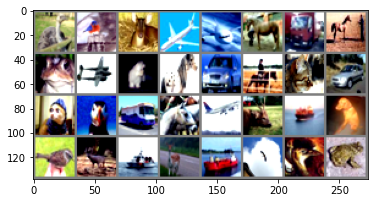

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:32]))



First, create your simple Neural Network consisting of a couple of feedforward layers (e.g. torch.nn.Linear) (**no convolutional layers required**). This model will take pretrained features as inputs. (20 points)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self):
        #Pretrained feature size 256 x 256
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(256, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)
        self.fc4 = nn.Linear(36, 10)


    def forward(self, x): 
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

simpleNet = SimpleNet().cuda()

Then, implement the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) by yourself. You are not permitted to use torch.nn.CrossEntropyLoss directly, but you can use other non-loss pytorch methods like torch.nn.LogSoftmax, etc.

For more information about loss functions, refer to https://cs231n.github.io/neural-networks-2/#losses . Basically, loss functions measures the compatibility between a prediction and the ground truth label. Cross entropy loss is the most widely used loss function for classification tasks. Here are some materials on cross entropy loss:

https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

https://medium.com/data-science-bootcamp/understand-cross-entropy-loss-in-minutes-9fb263caee9a

https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation

In [ ]:
import torch.optim as optim
import tensorflow as tf
import math

class myCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(myCrossEntropyLoss, self).__init__()
        self.logsm = nn.LogSoftmax()
    
    def forward(self, outputs, labels):
        # good article on cross entropy function for classification https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
        # might be using wrong dimension (feel like ouputs are a single columnn or row)
        out = self.logsm(outputs)    

        # reshape labels to give a flat vector of length batch_size*seq_len
        labels = labels.view(-1)  

        # mask out 'PAD' tokens
        mask = (labels >= 0).float()

        # the number of tokens is the sum of elements in mask
        num_tokens = int(torch.sum(mask))

        # pick the values corresponding to labels and multiply by mask
        out = out[range(out.shape[0]), labels]*mask

        # cross entropy loss for all non 'PAD' tokens
        return -torch.sum(out)/num_tokens

# define loss function
criterion = myCrossEntropyLoss()

# define optimizer. Pay attention to the arguments
optimizer = optim.Adam(simpleNet.parameters(), lr=0.0005)

Train the model on training images.

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # get pretrained features
        inputs = pretrainNet.pretrained_feature(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simpleNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,    50] loss: 1.906
[1,   100] loss: 1.240
[1,   150] loss: 1.057
[2,    50] loss: 0.897
[2,   100] loss: 0.871
[2,   150] loss: 0.886
[3,    50] loss: 0.837
[3,   100] loss: 0.804
[3,   150] loss: 0.814
[4,    50] loss: 0.777
[4,   100] loss: 0.783
[4,   150] loss: 0.782
[5,    50] loss: 0.771
[5,   100] loss: 0.759
[5,   150] loss: 0.763
[6,    50] loss: 0.737
[6,   100] loss: 0.742
[6,   150] loss: 0.757
[7,    50] loss: 0.728
[7,   100] loss: 0.749
[7,   150] loss: 0.721
[8,    50] loss: 0.727
[8,   100] loss: 0.722
[8,   150] loss: 0.712
[9,    50] loss: 0.725
[9,   100] loss: 0.708
[9,   150] loss: 0.725
[10,    50] loss: 0.692
[10,   100] loss: 0.713
[10,   150] loss: 0.711
[11,    50] loss: 0.701
[11,   100] loss: 0.692
[11,   150] loss: 0.708
[12,    50] loss: 0.686
[12,   100] loss: 0.695
[12,   150] loss: 0.711
[13,    50] loss: 0.683
[13,   100] loss: 0.705
[13,   150] loss: 0.685
[14,    50] loss: 0.676
[14,   100] loss: 0.695
[14,   150] loss: 0.669
[15,    50] loss: 0

Now, evaluate on the test images.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        images = pretrainNet.pretrained_feature(images)
        outputs = simpleNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %


## Problem 2: Training from scratch 
---
Now create your CNN model from scratch. This model will take raw images as input. You can refer to some representative CNN model architecture like [AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/), [VGGNet](https://pytorch.org/hub/pytorch_vision_vgg/), etc. You are **Not** required to implement residual connections like [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/). You are free to use layers like torch.nn.Conv2d, torch.nn.MaxPool2d, torch.nn.BatchNorm2d, torch.nn.Dropout, etc. 

You can use torch.nn.init to initialize the parameters. See https://pytorch.org/docs/stable/nn.html for api descriptions.

To make it simpler, we provided an examplar network. You could improve from this. We did not initialize weights explictly, but you are **requried** to do that.

**In order to get full credits, your test accuracy should be higher than acc_ta, where acc_ta is TA's implementation, shown in the block's output.**

You should keep training logs as they are in the block's output.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ExamplarNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def init_weights(m):
  if type(m) == nn.Linear or type(m) == nn.Conv2d:
    nn.init.xavier_uniform_(m.weight)

class FlattenImg(nn.Module):
  def forward(self, x):
    return x.view(-1, 16 * 5 * 5)

class Net(nn.Module):
    ##-------------TODO----------------# 
    def __init__(self):
        # build network and initialize weights by torch.nn.init
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5), nn.ReLU(),nn.MaxPool2d(2, 2),
            nn.Flatten()
            )
        self.layer2 = nn.Sequential(
            nn.BatchNorm1d(16 * 5 * 5),
            nn.Linear(16 * 5 * 5, 600), nn.ReLU(),
        )
        self.reslayer = nn.Sequential(
            nn.Linear(600, 600), nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(600, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )
        self.layer1.apply(init_weights)
        self.layer2.apply(init_weights)
        self.reslayer.apply(init_weights)
        self.layer4.apply(init_weights)

    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out + self.reslayer(out)
      out = self.layer4(out)
      return out

net = Net().cuda()

In [ ]:
import torch.optim as optim

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 2.310
[1,   100] loss: 2.061
[1,   150] loss: 1.895
[2,    50] loss: 1.710
[2,   100] loss: 1.656
[2,   150] loss: 1.645
[3,    50] loss: 1.550
[3,   100] loss: 1.514
[3,   150] loss: 1.511
[4,    50] loss: 1.456
[4,   100] loss: 1.448
[4,   150] loss: 1.434
[5,    50] loss: 1.390
[5,   100] loss: 1.384
[5,   150] loss: 1.382
[6,    50] loss: 1.352
[6,   100] loss: 1.323
[6,   150] loss: 1.321
[7,    50] loss: 1.288
[7,   100] loss: 1.301
[7,   150] loss: 1.294
[8,    50] loss: 1.250
[8,   100] loss: 1.252
[8,   150] loss: 1.240
[9,    50] loss: 1.230
[9,   100] loss: 1.199
[9,   150] loss: 1.211
[10,    50] loss: 1.187
[10,   100] loss: 1.198
[10,   150] loss: 1.182
[11,    50] loss: 1.153
[11,   100] loss: 1.167
[11,   150] loss: 1.151
[12,    50] loss: 1.125
[12,   100] loss: 1.140
[12,   150] loss: 1.142
[13,    50] loss: 1.130
[13,   100] loss: 1.111
[13,   150] loss: 1.093
[14,    50] loss: 1.064
[14,   100] loss: 1.101
[14,   150] loss: 1.072
[15,    50] loss: 1

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


## Problem 3: Fine Tuning a Pre-Trained Deep Network 
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks generalize surprisingly well to other recognition tasks. The pretrained model is obtained on Cifar-100 for 100 classes classification, and you will adapt it to Cifar-10 for 10 classes classification.

You should keep training logs as they are in the block's output.      
       
**Hints**:
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class FineTuneNet(nn.Module):
    def __init__(self):
        super(FineTuneNet, self).__init__()
        self.model_ft = ResNet().cuda()
        self.model_ft.load_state_dict(torch.load('./cifar100_net.pth'))
        self.model_ft.fc_layer = nn.Sequential(
            nn.Linear(256,100),
            nn.ReLU(),
            nn.Linear(100,10)
            )


    def forward(self, x):
        out = self.model_ft.forward(x)
        return out
        

fineTuneNet = FineTuneNet().cuda()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fineTuneNet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = fineTuneNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 2.041
[1,   100] loss: 1.383
[1,   150] loss: 1.090
[2,    50] loss: 0.849
[2,   100] loss: 0.791
[2,   150] loss: 0.775
[3,    50] loss: 0.695
[3,   100] loss: 0.653
[3,   150] loss: 0.640
[4,    50] loss: 0.592
[4,   100] loss: 0.590
[4,   150] loss: 0.585
[5,    50] loss: 0.537
[5,   100] loss: 0.541
[5,   150] loss: 0.535
[6,    50] loss: 0.496
[6,   100] loss: 0.493
[6,   150] loss: 0.503
[7,    50] loss: 0.459
[7,   100] loss: 0.477
[7,   150] loss: 0.452
[8,    50] loss: 0.441
[8,   100] loss: 0.437
[8,   150] loss: 0.424
[9,    50] loss: 0.413
[9,   100] loss: 0.402
[9,   150] loss: 0.408
[10,    50] loss: 0.378
[10,   100] loss: 0.383
[10,   150] loss: 0.391
[11,    50] loss: 0.364
[11,   100] loss: 0.357
[11,   150] loss: 0.361
[12,    50] loss: 0.331
[12,   100] loss: 0.349
[12,   150] loss: 0.352
[13,    50] loss: 0.321
[13,   100] loss: 0.318
[13,   150] loss: 0.325
[14,    50] loss: 0.296
[14,   100] loss: 0.312
[14,   150] loss: 0.297
[15,    50] loss: 0

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = fineTuneNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


<!--Write your report here in markdown or html-->
